The main aim of EDA is to analyze the MTA data set in order to come out with the subway stations for deployment of street teams for maximum signatures.

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(palette="deep")

In [2]:
pwd

'C:\\Users\\KiraWong\\Downloads'

# Field Description

C/A      = Control Area (A002)  
UNIT     = Remote Unit for a station (R051)  
SCP      = Subunit Channel Position represents an specific address for a device (02-00-00)  
STATION  = Represents the station name the device is located at  
LINENAME = Represents all train lines that can be boarded at this station  
           Normally lines are represented by one character.  LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains.  
DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND     
DATE     = Represents the date (MM-DD-YY)  
TIME     = Represents the time (hh:mm:ss) for a scheduled audit event  
DESc     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)  
1. Audits may occur more that 4 hours due to planning, or troubleshooting activities.   
2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered.     

ENTRIES  = The comulative entry register value for a device  
EXIST    = The cumulative exit register value for a device  

In [3]:
# Load data and rename the columns
df_200411 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_200411.txt")
df_200411.columns = ['C/A','Unit','SCP','Station','Linename','Division','Date','Time','Desc','Entries','Exits']      

In [4]:
# Convert date from object to datetime format
df_200411['Date'] = pd.to_datetime(df_200411['Date'], format='%M/%d/%Y')
# Extract hour from time object and populate this inot a new column called hour
df_200411['hour'] = pd.to_datetime(df_200411['Time'], format='%H:%M:%S').dt.hour
df_200411.head(5)

,C/A,Unit,SCP,Station,Linename,Division,Date,Time,Desc,Entries,Exits,hour
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-01-04 00:04:00,00:00:00,REGULAR,7413507,2516927,0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-01-04 00:04:00,04:00:00,REGULAR,7413507,2516927,4
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-01-04 00:04:00,08:00:00,REGULAR,7413511,2516935,8
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-01-04 00:04:00,12:00:00,REGULAR,7413521,2516944,12
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-01-04 00:04:00,16:00:00,REGULAR,7413541,2516953,16


In [5]:
df_200411.info() #inspect the columns and datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205981 entries, 0 to 205980
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   C/A       205981 non-null  object        
 1   Unit      205981 non-null  object        
 2   SCP       205981 non-null  object        
 3   Station   205981 non-null  object        
 4   Linename  205981 non-null  object        
 5   Division  205981 non-null  object        
 6   Date      205981 non-null  datetime64[ns]
 7   Time      205981 non-null  object        
 8   Desc      205981 non-null  object        
 9   Entries   205981 non-null  int64         
 10  Exits     205981 non-null  int64         
 11  hour      205981 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 18.9+ MB


In [6]:
# Concatenate C/A, Unit and SCP as unique Turnstile ID, and put in new column
df_200411['Turnstile_ID'] = df_200411['C/A'] + '-' + df_200411['Unit'] + '-' + df_200411['SCP']

In [7]:
# Count the number of unique values of all the columns
df_200411.nunique()

C/A                746
Unit               469
SCP                222
Station            378
Linename           114
Division             6
Date                 7
Time             12358
Desc                 2
Entries         155595
Exits           160375
hour                24
Turnstile_ID      4931
dtype: int64

## Removal of early and late hours   
We define early hours as those before 0600, a and late hours for those after 2000 hours.
For these early and late hours we do not expect these numbers to be significant and thus will be omitted from our dataset for analysis.


In [8]:
# Inspect the different hours in the data
df_200411.hour.unique()

array([ 0,  4,  8, 12, 16, 20,  2,  6, 10, 14, 18, 22,  1,  5,  9, 13, 17,
       21,  7,  3, 11, 15, 19, 23], dtype=int64)

In [9]:
# Define early hours as before 0600 hours, and drop these hours
early_hrs = df_200411[(df_200411['hour'] < 6)].index
df_200411.drop(early_hrs, inplace=True)
df_200411.hour.unique()

array([ 8, 12, 16, 20,  6, 10, 14, 18, 22,  9, 13, 17, 21,  7, 11, 15, 19,
       23], dtype=int64)

In [10]:
# Define late hours as after 2000 hours, and drop these hours
late_hrs = df_200411[(df_200411['hour'] > 20)].index
df_200411.drop(late_hrs, inplace=True)
df_200411.hour.unique()

array([ 8, 12, 16, 20,  6, 10, 14, 18,  9, 13, 17,  7, 11, 15, 19],
      dtype=int64)

In [ ]:
df_200411['Net_Entries'] = df_200411.groupby(['Turnstile_ID','Station','Date'])['Entries'].transform(pd.Series.diff)

In [ ]:
df_200411['Net_Exits'] = df_200411.groupby(['Turnstile_ID','Station','Date'])['Exits'].transform(pd.Series.diff)

In [ ]:
df_200411['Net_Entries'].clip(lower=0, inplace = True)

In [14]:
df_200411['Net_Exits'].clip(lower=0, inplace = True)

In [15]:
df_200411['Net_Entries'].fillna(0, inplace = True)

In [ ]:
df_200411['Net_Exits'].fillna(0, inplace = True)

In [ ]:
summary_df.to_excel (r'1.xlsx', index = False, header=True)

In [18]:
df_200411.nunique()

C/A                746
Unit               469
SCP                222
Station            378
Linename           114
Division             6
Date                 7
Time              7729
Desc                 2
Entries         101003
Exits           102011
hour                15
Turnstile_ID      4931
Net_Entries        228
Net_Exits          296
dtype: int64

In [19]:
#df_200411.to_excel (r'export_dataframe5.xlsx', index = False, header=True)

In [20]:
df_200411['Daily_Entries'] = df_200411.groupby(['Station','Date'])['Net_Entries'].transform(pd.Series.sum)

In [21]:
df_200411['Daily_Exits'] = df_200411.groupby(['Station','Date'])['Net_Exits'].transform(pd.Series.sum)

In [22]:
df_1 = df_200411.reset_index().drop_duplicates(subset=['Station', 'Date'],
                                       keep='first').set_index('index')

In [23]:
df_1.nunique()

C/A               378
Unit              367
SCP                11
Station           378
Linename           94
Division            6
Date                7
Time              144
Desc                2
Entries          2523
Exits            2510
hour                8
Turnstile_ID      379
Net_Entries         1
Net_Exits           1
Daily_Entries    1163
Daily_Exits      1215
dtype: int64

In [ ]:
df_1.to_excel (r'export_dataframe6.xlsx', index = False, header=True)

In [24]:
summary_df = df_1[['Date', 'Station', 'Daily_Entries','Daily_Exits']]

In [35]:
summary_df['Daily_Traffic'] = summary_df['Daily_Entries'] + summary_df['Daily_Exits']

C:\Users\KiraWong\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
summary_df.to_excel (r'export_dataframe8.xlsx', index = False, header=True)

In [27]:
summary_df.nlargest(40,'Daily_Traffic')

,Date,Station,Daily_Entries,Daily_Exits,Daily_Traffic
index,,,,,
46802,2020-01-06 00:04:00,125 ST,6287.0,7803.0,14090.0
46826,2020-01-10 00:04:00,125 ST,5761.0,7840.0,13601.0
46808,2020-01-07 00:04:00,125 ST,6037.0,7446.0,13483.0
46814,2020-01-08 00:04:00,125 ST,6062.0,7418.0,13480.0
46820,2020-01-09 00:04:00,125 ST,5573.0,6989.0,12562.0
53580,2020-01-06 00:04:00,34 ST-PENN STA,5208.0,7087.0,12295.0
53586,2020-01-07 00:04:00,34 ST-PENN STA,4866.0,6741.0,11607.0
53598,2020-01-09 00:04:00,34 ST-PENN STA,4731.0,6757.0,11488.0
53604,2020-01-10 00:04:00,34 ST-PENN STA,4508.0,6791.0,11299.0


In [28]:
summary_df[summary_df['Daily_Traffic'].isin(summary_df.groupby('Date').max()['Daily_Traffic'].values)]

,Date,Station,Daily_Entries,Daily_Exits,Daily_Traffic
index,,,,,
46790,2020-01-04 00:04:00,125 ST,4198.0,6209.0,10407.0
46796,2020-01-05 00:04:00,125 ST,3294.0,4782.0,8076.0
46802,2020-01-06 00:04:00,125 ST,6287.0,7803.0,14090.0
46808,2020-01-07 00:04:00,125 ST,6037.0,7446.0,13483.0
46814,2020-01-08 00:04:00,125 ST,6062.0,7418.0,13480.0
46820,2020-01-09 00:04:00,125 ST,5573.0,6989.0,12562.0
46826,2020-01-10 00:04:00,125 ST,5761.0,7840.0,13601.0


In [29]:
top3 = summary_df.loc[summary_df.groupby('Date')['Daily_Traffic'].nlargest(5).index.get_level_values(1)]
top3

,Date,Station,Daily_Entries,Daily_Exits,Daily_Traffic
index,,,,,
46790,2020-01-04 00:04:00,125 ST,4198.0,6209.0,10407.0
53568,2020-01-04 00:04:00,34 ST-PENN STA,2629.0,4347.0,6976.0
24016,2020-01-04 00:04:00,86 ST,2692.0,3443.0,6135.0
4900,2020-01-04 00:04:00,14 ST-UNION SQ,2122.0,2907.0,5029.0
3314,2020-01-04 00:04:00,34 ST-HERALD SQ,1932.0,2942.0,4874.0
46796,2020-01-05 00:04:00,125 ST,3294.0,4782.0,8076.0
53574,2020-01-05 00:04:00,34 ST-PENN STA,2146.0,3558.0,5704.0
24022,2020-01-05 00:04:00,86 ST,2132.0,2825.0,4957.0
51459,2020-01-05 00:04:00,42 ST-PORT AUTH,1523.0,2423.0,3946.0


In [30]:
top3['Date'] = pd.to_datetime(top3['Date'], format = '%Y-%m-%d')
top3['Day'] = top3['Date'].dt.day_name()
top3

,Date,Station,Daily_Entries,Daily_Exits,Daily_Traffic,Day
index,,,,,,
46790,2020-01-04 00:04:00,125 ST,4198.0,6209.0,10407.0,Saturday
53568,2020-01-04 00:04:00,34 ST-PENN STA,2629.0,4347.0,6976.0,Saturday
24016,2020-01-04 00:04:00,86 ST,2692.0,3443.0,6135.0,Saturday
4900,2020-01-04 00:04:00,14 ST-UNION SQ,2122.0,2907.0,5029.0,Saturday
3314,2020-01-04 00:04:00,34 ST-HERALD SQ,1932.0,2942.0,4874.0,Saturday
46796,2020-01-05 00:04:00,125 ST,3294.0,4782.0,8076.0,Sunday
53574,2020-01-05 00:04:00,34 ST-PENN STA,2146.0,3558.0,5704.0,Sunday
24022,2020-01-05 00:04:00,86 ST,2132.0,2825.0,4957.0,Sunday
51459,2020-01-05 00:04:00,42 ST-PORT AUTH,1523.0,2423.0,3946.0,Sunday


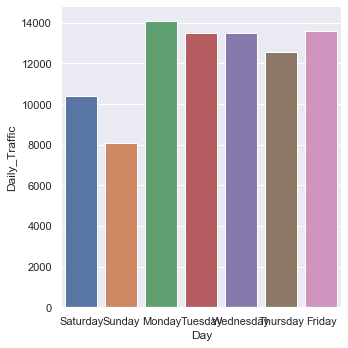

In [31]:
# station_1 = list(top3[top3['Station'] == '125 ST']['Day'])
df_top1 = top3[top3.Station == '125 ST']
sns.catplot(x="Day", y='Daily_Traffic', kind="bar",  data=df_top1)

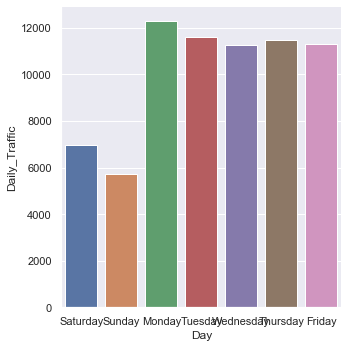

In [32]:
df_top2 = top3[top3.Station == '34 ST-PENN STA']
sns.catplot(x="Day", y='Daily_Traffic', kind="bar",  data=df_top2)

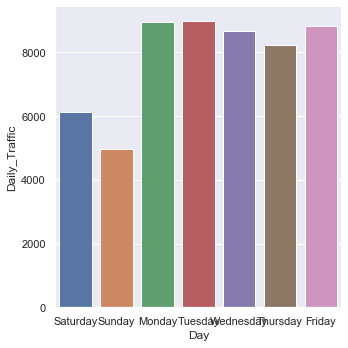

In [33]:
df_top3 = top3[top3.Station == '86 ST']
sns.catplot(x="Day", y='Daily_Traffic', kind="bar",  data=df_top3)

C:\Users\KiraWong\anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


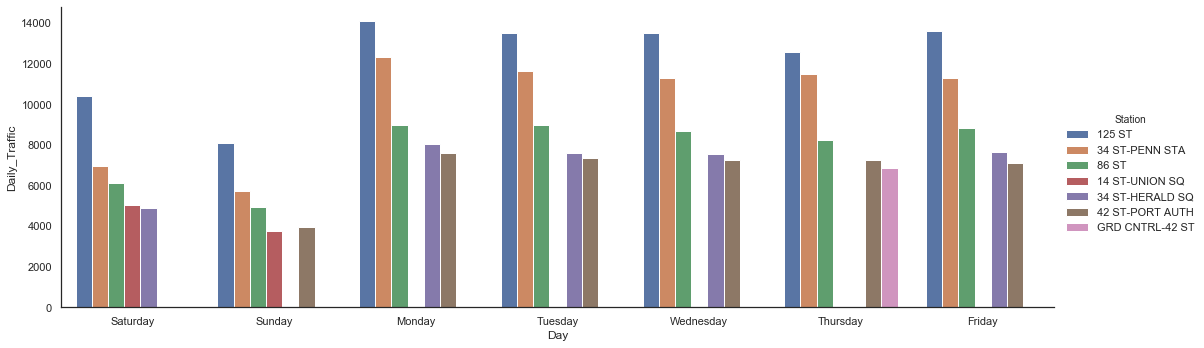

In [34]:
with sns.axes_style('white'):
    g = sns.factorplot("Day", "Daily_Traffic",data=top3, aspect=3.0, kind='bar',
                       hue='Station')
    g.set_ylabels('Daily_Traffic')